In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-08-08 18:17:42.168193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 18:17:42.182043: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 18:17:42.358210: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 18:17:42.489477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 18:17:42.598253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [5]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)
data_dir = pathlib.Path('./iga_severidades')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

89


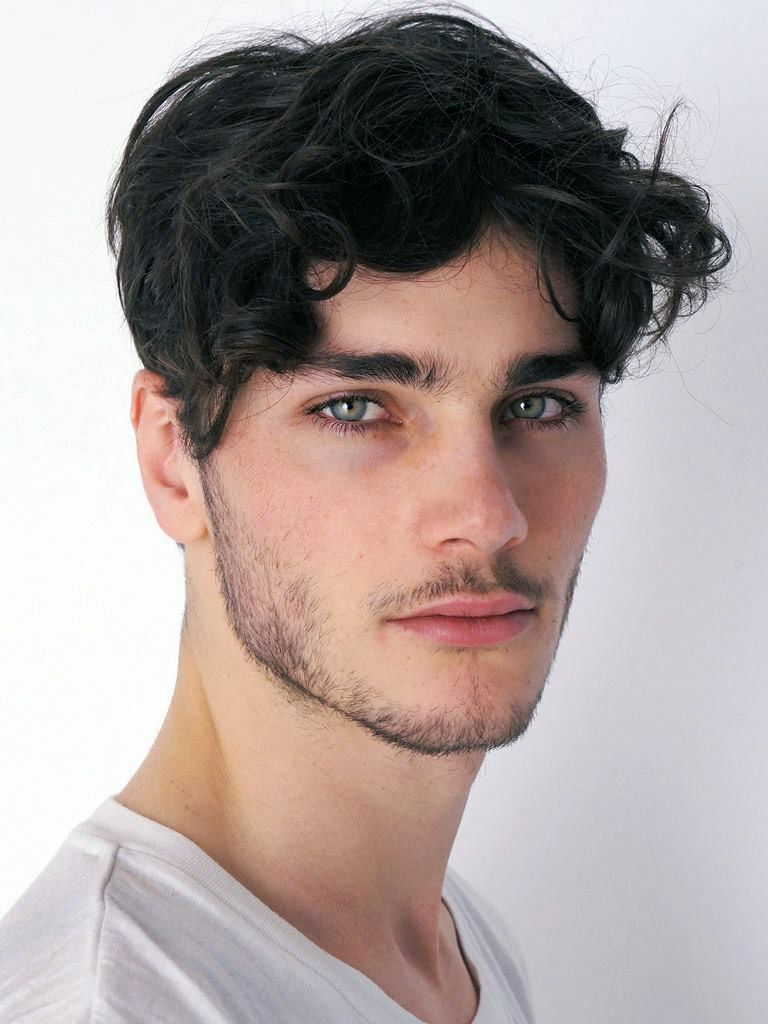

In [8]:
severity_0 = list(data_dir.glob('Severidade 0/*'))
PIL.Image.open(str(severity_0[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 91 files belonging to 5 classes.
Using 73 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 91 files belonging to 5 classes.
Using 18 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['Severidade 0', 'Severidade 1', 'Severidade 2', 'Severidade 3', 'Severidade 4']


2024-08-07 19:59:05.657325: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47775744 exceeds 10% of free system memory.
2024-08-07 19:59:05.687459: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48552960 exceeds 10% of free system memory.
2024-08-07 19:59:05.804873: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47775744 exceeds 10% of free system memory.
2024-08-07 19:59:06.193474: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66355200 exceeds 10% of free system memory.
2024-08-07 19:59:06.219308: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60341760 exceeds 10% of free system memory.
2024-08-07 19:59:07.112380: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


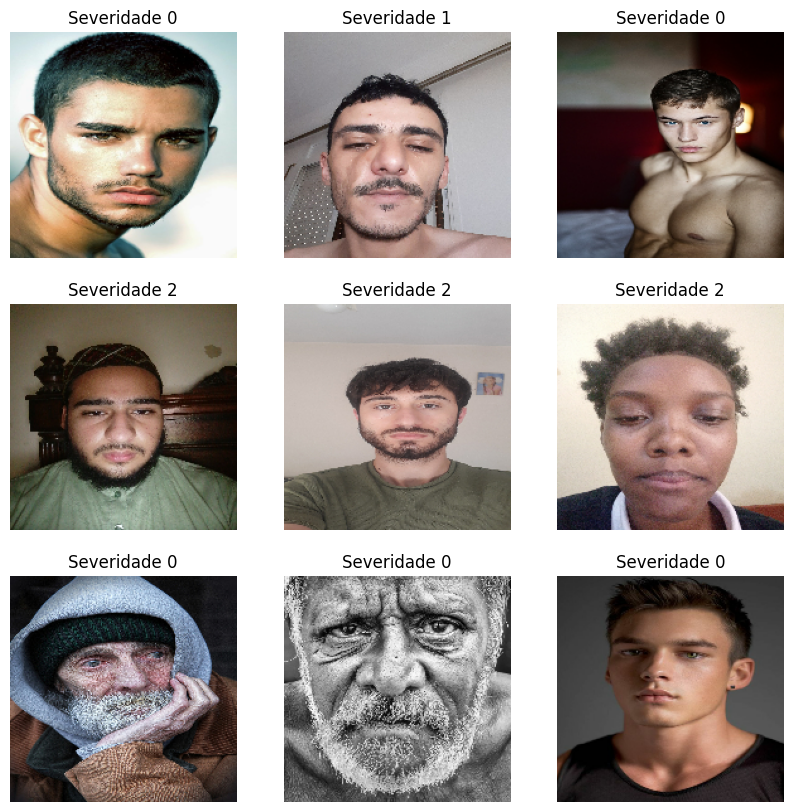

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9370183


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/seth/Desktop/python/machine_learning/test_cnn/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 972ms/step - accuracy: 0.1800 - loss: 2.1363 - val_accuracy: 0.1111 - val_loss: 2.6210
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - accuracy: 0.3435 - loss: 1.8033 - val_accuracy: 0.2222 - val_loss: 1.6455
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.4134 - loss: 1.5209 - val_accuracy: 0.2778 - val_loss: 1.5792
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.4095 - loss: 1.4524 - val_accuracy: 0.1111 - val_loss: 1.5806
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.4254 - loss: 1.3132 - val_accuracy: 0.3333 - val_loss: 1.4953
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - accuracy: 0.6213 - loss: 1.2218 - val_accuracy: 0.2778 - val_loss: 1.5869
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - accuracy: 0.6904 - loss: 0.9924 - val_accuracy: 0.3333 - val_loss: 1.7009
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.7959 - loss: 0.6883 - val_accuracy: 0.2778 - val_loss:

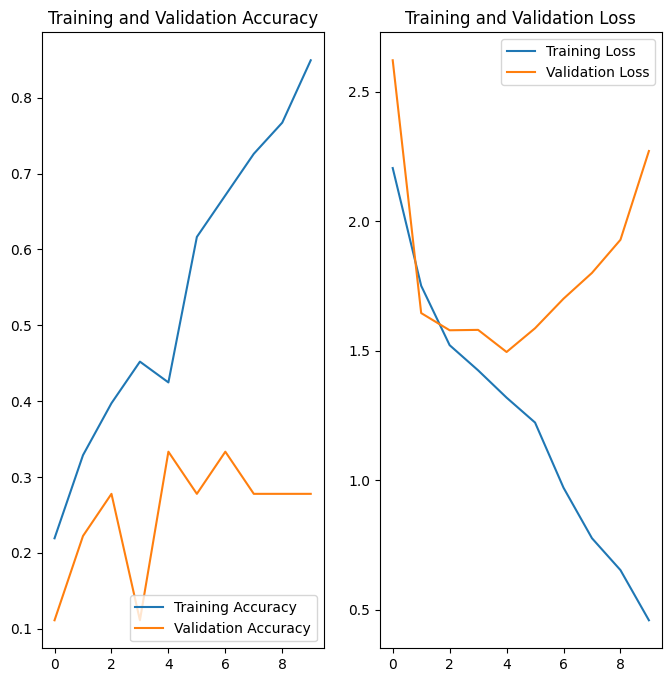

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/seth/Desktop/python/machine_learning/test_cnn/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-08-07 20:03:18.275066: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


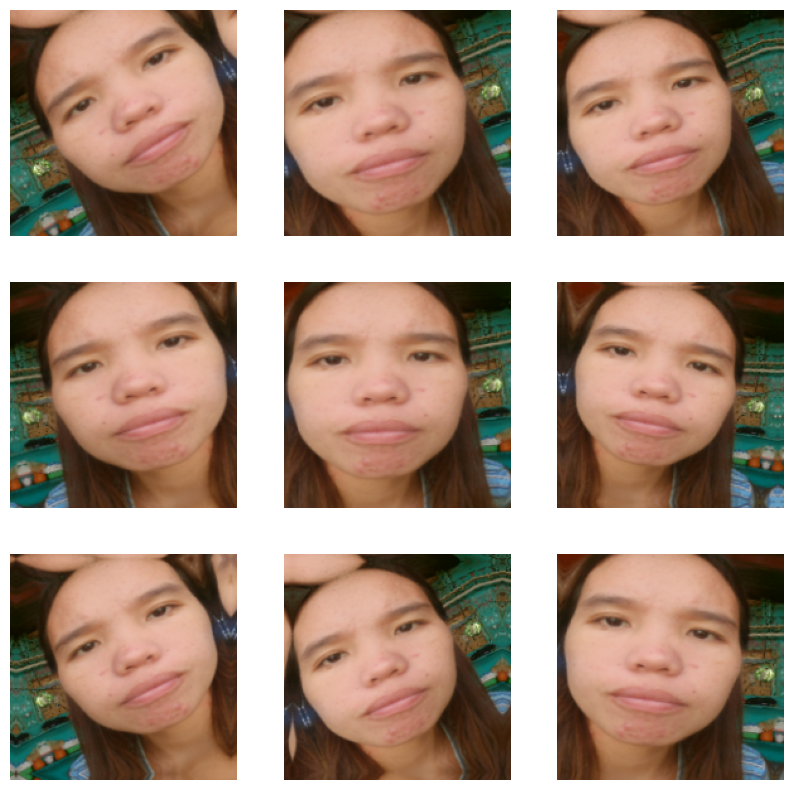

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - accuracy: 0.2124 - loss: 1.7858 - val_accuracy: 0.1111 - val_loss: 1.6935
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.2543 - loss: 1.5558 - val_accuracy: 0.1111 - val_loss: 1.6778
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.3118 - loss: 1.5171 - val_accuracy: 0.1111 - val_loss: 1.6581
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step - accuracy: 0.3251 - loss: 1.5021 - val_accuracy: 0.1111 - val_loss: 1.6202
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.3690 - loss: 1.4470 - val_accuracy: 0.1111 - val_loss: 1.6741
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 0.3558 - loss: 1.3760 - val_accuracy: 0.2778 - val_loss: 1.7003
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.4819 - loss: 1.2822 - val_accuracy: 0.3333 - val_loss: 1.7298
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.5333 - loss: 1.1604 - val_accuracy: 0.3889 - val_loss:

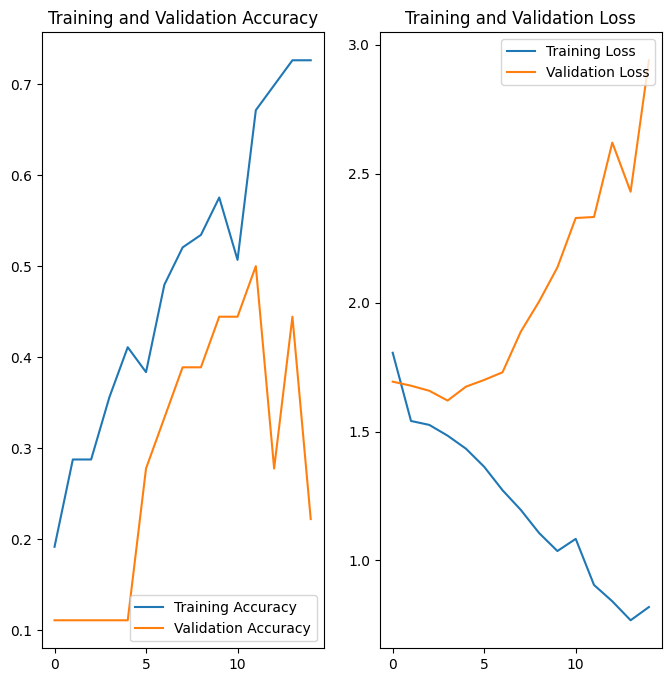

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
image_to_predict = './acne04_to_test/acne_1024/acne3_1024/levle3_0.jpg'

img = tf.keras.utils.load_img(
    image_to_predict, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image most likely belongs to Severidade 2 with a 79.62 percent confidence.
